# Сборный проект #1

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sn
df = pd.read_csv('/datasets/games.csv')

In [2]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


**Вывод:** В данных есть пропуски, это касается значений оценок пользователей и критиков, а так же рейтинга.

### 2. Подготовим данные

Приведем названия столбцов к нижнему регистру:

In [5]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Преобразуем данные в нужные типы:

In [6]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
df['rating'] = df['rating'].fillna('undefined')
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [7]:
df.dropna(subset=['year_of_release'], inplace=True)
df.dropna(subset=['name'], inplace=True)
df.dropna(subset=['genre'], inplace=True)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,undefined
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,undefined
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,undefined


In [8]:
df['year_of_release'] = df['year_of_release'].astype(int)
df['user_score'] = df['user_score'].astype(float)
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()
df['name'] = df['name'].str.lower()

In [9]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,undefined
16711,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,NaN,NaN,undefined
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined
16713,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,NaN,NaN,undefined


Мы заменили данные в столбце с годом релиза игры, привели его к целочисленному значению.  
Еще изменили тип данных в столбце user_score с object на float, для этого потребовалось поменять такое значение как 'tbd' на 0.

Теперь посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец:

In [10]:
df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16711,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,NaN,NaN,undefined,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16713,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,NaN,NaN,undefined,0.01


### 3. Проведем исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы:

In [11]:
df.pivot_table(index='year_of_release', values='name', aggfunc='count')

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


**Вывод:** пик по количеству выпущенных игр пришелся на **середину 2000х** с **2006** по **2011** годы включительно выходило более **1000 игр.**

Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. Ответим на вопрос: "3а какой характерный срок появляются новые и исчезают старые платформы?".

In [12]:
df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(10)

,total_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


Определили топ10 по продажам за все время.

Сделаем срез основного датафрейма по **TOP10** в стобец **'platform':**

In [13]:
query = df.query('platform  in ("ps2","x360","ps3","wii","ds","ps","gba","ps4","psp","pc")')

Создадим сводную таблицу, просуммируем продажи в зависимости от платформы и года выпуска:

In [14]:
query = query.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum').reset_index().sort_values(by='total_sales',ascending=False).head(30)
query

,platform,year_of_release,total_sales
59,ps2,2004,211.81
97,wii,2009,206.97
57,ps2,2002,205.38
58,ps2,2003,184.31
96,wii,2008,171.32
110,x360,2010,170.03
49,ps,1998,169.49
56,ps2,2001,166.43
60,ps2,2005,160.66
72,ps3,2011,156.78


In [15]:
query['platform'].value_counts()

ps3     6
ps2     6
wii     5
ds      5
x360    4
ps      3
ps4     1
Name: platform, dtype: int64

Как мы видим жизненый цикл и максимальные продажи приходятся на период **3-6 лет.**


Для формирования прогноза на 2017 года я определяю **актуальный** период в 3 года (2014, 2015, 2016 года).

Сделаем срез за 3 года:

In [16]:
three_y = [2014,2015,2016]
last3y = df.query("year_of_release in @three_y")
last3y

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,undefined,11.68
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,undefined,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01


Определим лидирующие платформы по продажам:

In [17]:
last3y.pivot_table(index='platform',values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

,total_sales
platform,
ps4,288.15
xone,140.36
3ds,86.68
ps3,68.18
x360,48.22
wiiu,42.98
pc,27.05
psv,22.40
wii,5.07


В лидерах **Playstation 4**, на 2м месте **Xbox One**, замыкает тройку лидеров **Nintendo 3ds**

Построим график «ящик с усами» по глобальным продажам игр для тройки лидеров.

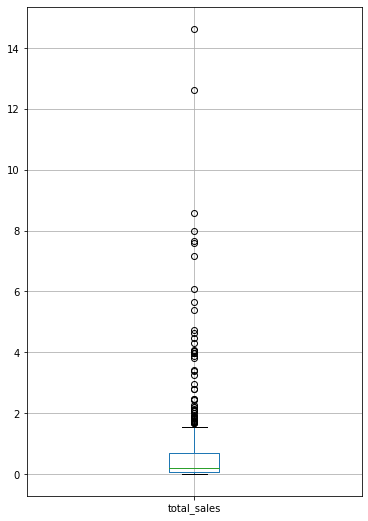

In [18]:
last3y[last3y['platform']=='ps4'].boxplot(column='total_sales', figsize=(6,9));

In [19]:
last3y[last3y['platform']=='ps4']['total_sales'].describe()

count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: total_sales, dtype: float64

**Вывод:** 75% игр на платформе ps4 продавались за последние 3 года тиражом не более 690 тыс. копий

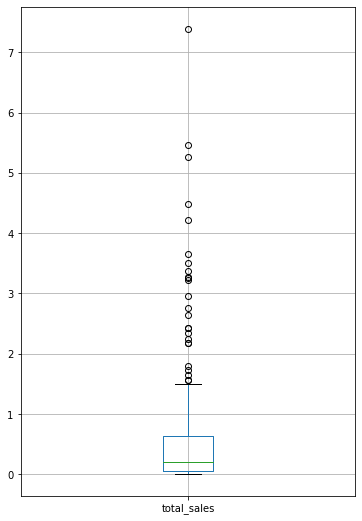

In [20]:
last3y[last3y['platform']=='xone'].boxplot(column='total_sales', figsize=(6,9));

In [21]:
last3y[last3y['platform']=='xone']['total_sales'].describe()

count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64

**Вывод:** 75% игр на платформе xbox one продавались за последние 3 года тиражом не более 632.5 тыс. копий. Очень близкий результат к PlayStation4.


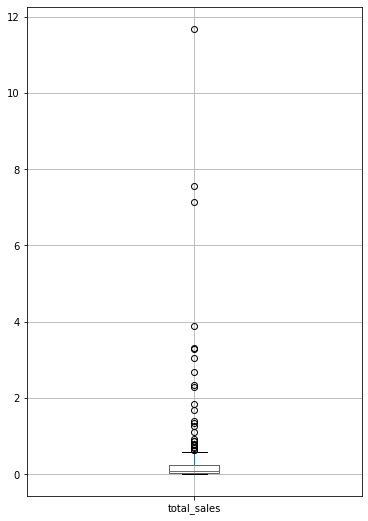

In [22]:
last3y[last3y['platform'] =='3ds'].boxplot(column='total_sales', figsize=(6,9));

In [23]:
last3y[last3y['platform']=='3ds']['total_sales'].describe()

count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: total_sales, dtype: float64

**Вывод:** 75% игр на платформе **Nintendo 3ds** продавались за последние 3 года тиражом не более 250 тыс. копий. Заметно ниже, чем у первых двух лидеров!

**Общий вывод:** выбросы - лидеры продаж, популярные игры, хиты игровой индустрии.  
Учитывая приблизительное равенство в количестве игр между **ps4** и **xbox**, но при этом двойное превосходство первой по количеству проданных копий и приблизительное равенство 75% обоих платформ по продажам, мы делаем вывод, что хитов и популярных игр на ps4 выходило больше, превосходство в 2 раза говорит о многом.

In [25]:
last3y

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,undefined,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,undefined,11.68
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,undefined,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,undefined,0.01


Построим диаграмму рассеяния отзывов критиков и количества продаж для **PS4:**

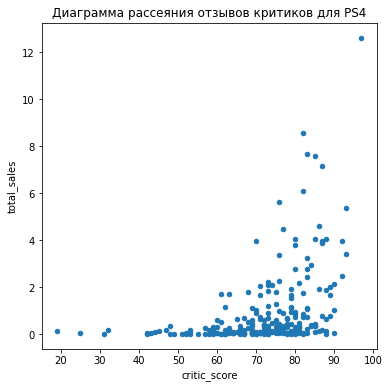

In [26]:
(
last3y[last3y['platform']=='ps4']
    .plot(title='Диаграмма рассеяния отзывов критиков для PS4', x='critic_score', y='total_sales', kind='scatter', figsize=(6,6))
);

Посчитаем корреляцию между отзывами критиков и количеством продаж:

In [27]:
last3y[last3y['platform']=='ps4']['critic_score'].corr(last3y[last3y['platform']=='ps4']['total_sales'])

0.40266141068104083

Низкая степень корреляции

Теперь построим диаграмму рассеяния отзывов пользователей и количества продаж для PS4:

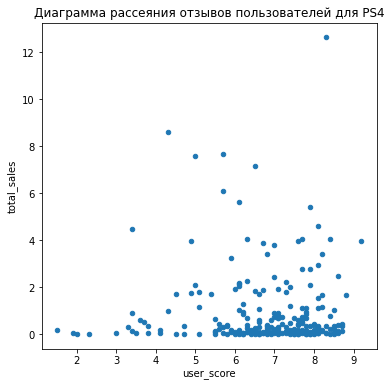

In [28]:
(
last3y[last3y['platform']=='ps4']
    .plot(title='Диаграмма рассеяния отзывов пользователей для PS4', x='user_score', y='total_sales', kind='scatter', figsize=(6,6))
);

Посчитаем корреляцию между отзывами пользователей и количеством продаж:

In [29]:
last3y[last3y['platform']=='ps4']['user_score'].corr(last3y[last3y['platform']=='ps4']['total_sales'])

-0.040131589472697356

Степень корреляции еще ниже, чем в предыдущем опыте.

**Общий вывод:** рейтинг на основании отзывов критиков или пользователей оказывают среднее и низкое влияние на продажи, степень корреляции составляет **0.4** и **-0.04** соответственно.

Теперь проверим корреляцию между отзывами и продажами на **других платформах:**

Посчитаем корреляцию между отзывами критиков и количеством продаж:

In [30]:
last3y[last3y['platform']!='ps4']['critic_score'].corr(last3y[last3y['platform']!='ps4']['total_sales'])

0.3094740026001152

Посчитаем корреляцию между отзывами пользователей и количеством продаж:

In [31]:
last3y[last3y['platform']!='ps4']['user_score'].corr(last3y[last3y['platform']!='ps4']['total_sales'])

-0.02347818723797556

**Общий вывод:** все так же средня и низкая степень корреляции между этими двумя показателями, платформа не имеет значения.

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [32]:
genres = last3y.pivot_table(index='genre',values='total_sales', aggfunc=['count', 'sum', 'mean']).reset_index()
genres.columns=['genre','count','sum', 'mean']
genres.sort_values(by='sum', ascending=False)

,genre,count,sum,mean
0,action,619,199.36,0.322068
8,shooter,128,170.94,1.335469
10,sports,161,109.48,0.680000
7,role-playing,221,101.44,0.459005
3,misc,113,37.55,0.332301
2,fighting,60,28.22,0.470333
6,racing,69,27.52,0.398841
4,platform,38,18.09,0.476053
1,adventure,185,17.55,0.094865
9,simulation,44,13.13,0.298409


**Вывод:** : жанр **"экшн"** лидер по числу проданных копий, но это с условием, что количество игр в 5 раз больше, чем у ближайшего преследователя - жанра **"шутер"**. Так же выделим жанр **"спорт"**. В аутсайдерах выделим жанр "эдвенчар", при высоком количестве игр самый низкий удельный показатель проданных копий.

###  4. Составим портрет пользователя каждого региона. Определим для пользователя каждого региона (NA, EU, JP)    
- Самые популярные платформы (топ-5). Опишим различия в долях продаж.  
- Самые популярные жанры (топ-5). Поясним разницу.  
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Определим самые популярные платформы (топ-5). Опишим различия в долях продаж:  
Для начала определим топов в **Северной Америке:**

In [33]:
(
last3y
    .pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales',ascending=False).head().reset_index()
)

,platform,na_sales
0,ps4,98.61
1,xone,81.27
2,x360,28.30
3,3ds,22.64
4,ps3,22.05


В **Северной Америке**  за последние **3 года** лидирует **PlayStation 4**, на ее счету **98,61 млн** проданных копий игр. Чуть чуть позади **Xbox One**, получается почти паритет между конкурентами. Остальные три приставки значительно отстают по продажам.

Теперь посмотрим кто в лидерах в **Европе:**

In [34]:
(
last3y
    .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales',ascending=False).head().reset_index()
)

,platform,eu_sales
0,ps4,130.04
1,xone,46.25
2,ps3,25.54
3,pc,17.97
4,3ds,16.12


В сравнении с **NA** можно отметить что **PlayStation 4** лидирует с троекратным отрывом от **Xbox One**. Так же отметим, что в **TOP5** вошла платформа **PC.**

Рассмотрим ситуацию в **Японии:**

In [35]:
(
last3y
    .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales',ascending=False).head().reset_index()
)

,platform,jp_sales
0,3ds,44.24
1,ps4,15.02
2,psv,14.54
3,ps3,11.22
4,wiiu,7.31


Здесь лидер совершенно другой, в отлиичии от **NA** и **EU**, платформа **Nintendo 3ds** лидирует с **44.24 млн.** проданных копий за **3 года**, причем отрыв от ближайшего преследователя - **PlayStation 4** троекратный.

Теперь рассмотрим рынки по жанрам:

Начнем с **Северной Америки**, определим **TOP5** жанров:

In [36]:
(
last3y
    .pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False).head().reset_index()
)

,genre,na_sales
0,shooter,79.02
1,action,72.53
2,sports,46.13
3,role-playing,33.47
4,misc,15.05


В авангарде **"шутеры"** и **"экшены"**, **спортивные игры** замыкают тройку лидеров.

А что в **Европе?:**

In [37]:
(
last3y
    .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales',ascending=False).head().reset_index()
)

,genre,eu_sales
0,action,74.68
1,shooter,65.52
2,sports,45.73
3,role-playing,28.17
4,racing,14.13


Лидеры все те же, только теперь на первом месте жанр **"Action"**, количество проданных копий в **Европе** так же сопоставимо с **Северной Америкой**, из замыкающих в **Европе** вместо жанра **"Misc"** появился жанр **"Racing'.**

Теперь перейдем к **Японии:**

In [38]:
(
last3y
    .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales',ascending=False).head().reset_index()
)

,genre,jp_sales
0,role-playing,31.16
1,action,29.58
2,fighting,6.37
3,misc,5.61
4,shooter,4.87


Японцы не перестают удивлять, в лидерах жанр **"Role-playing"**, так же можно отметитьв топ5 жанр **"Fighting"**,  в **EU** и **NA** этот жанр не вошел в **TOP5**

Теперь рассмотрим степень влияния рейтинга **ESRB** на продажи:  
+ «M» («Mature») — «Для взрослых»  
+ «E» («Everyone») — «Для всех»  
+ «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»  
+ «T» («Teen») — «Подросткам»

Начнем как обычно с **Северной Америки:**

In [39]:
(
last3y
    .pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales',ascending=False).head().reset_index()
)

,rating,na_sales
0,M,96.42
1,undefined,64.72
2,E,50.74
3,T,38.95
4,E10+,33.23


В лидерах категория **"для взрослых"**, следом идет большая часть игр **без рейтинга**, замыкает тройку лидеров категория **"для всех"**

**Европа:**

In [40]:
(
last3y
    .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales',ascending=False).head().reset_index()
)

,rating,eu_sales
0,M,93.44
1,undefined,58.95
2,E,58.06
3,T,34.07
4,E10+,26.16


В лидерах категория **"для взрослых"**, следом идет большая часть игр **без рейтинга**, замыкает тройку лидеров категория **"для всех"**

**Япония:**

In [41]:
(
last3y
    .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales',ascending=False).head().reset_index()
)

,rating,jp_sales
0,undefined,56.90
1,T,14.78
2,E,8.94
3,M,8.01
4,E10+,4.46


Большая часть игр **без рейтинга**, на втором месте игры с рейтингом **"подросткам"**, на третьем - **"для всех".**

###  5. Проверим гипотезы

+ Средние пользовательские рейтинги платформ **Xbox One** и **PC** одинаковые;
+ Средние пользовательские рейтинги жанров **Action** (англ. «действие», экшен-игры) и **Sports** (англ. «спортивные соревнования») разные.

Сформируем **нулевую** и **альтернативную** гипотезу для каждого задания:
1. **Нулевая** гипотеза гласит - средние пользовательские рейтинги платформ **Xbox One** и **PC** не имеют статистически значимую разницу.  
   **Альтернативная** гипотеза - средние имеют стат. значимую разницу.
   
2. **Нулевая** гипотеза гласит - средние пользовательские рейтинги жанров **Action** (англ. «действие», экшен-игры) и **Sports** (англ. «спортивные соревнования») не имеют статистически значимую разницу.
   **Альтернативная** гипотеза -  средние имеют стат. значимую разницу.

Проверим одинаковые ли средние пользовательские рейтинги платформ **Xbox One** и **PC:**

Для начала сравним дисперсии выборок, дабы корректно определить атрибут **equal_val** в Т–тесте.

In [42]:
variance_xbox_one = np.var(last3y[last3y['platform']=='xone']['user_score'])
variance_xbox_one

1.879546005509642

In [43]:
variance_pc = np.var(last3y[last3y['platform']=='pc']['user_score'])
variance_pc

2.8773743617307175

Мы видим, что дисперсии выборок отличаются, поэтому установим атрибут **equal_val=False**

In [44]:
xbox = last3y[last3y['platform']=='xone']['user_score']
pc = last3y[last3y['platform']=='pc']['user_score']
alpha = 0.05
results = st.ttest_ind(xbox, pc, equal_var = False, nan_policy = 'omit')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.11601398086668943
Не получилось отвергнуть нулевую гипотезу


Действительно, мы можем утверждать, что средние пользовательские рейтинги платформ **Xbox One** и **PC**  не имеют статистически значимую разницу. .

Теперь проверим  одинаковые ли средние пользовательские рейтинги жанров **Action**  и **Sports:** 

Сравним дисперсии выборок, дабы корректно определить атрибут **equal_val** в Т–тесте:

In [45]:
variance_action = np.var(last3y[last3y['genre']=='action']['user_score'])
variance_action

1.89208448117539

In [46]:
variance_sports = np.var(last3y[last3y['genre']=='sports']['user_score'])
variance_sports

3.419837559675119

Дисперсии выборок отличаются, поэтому установим атрибут **equal_val=False**

In [47]:
action = last3y[last3y['genre']=='action']['user_score']
sports = last3y[last3y['genre']=='sports']['user_score']
alpha = 0.05
results = st.ttest_ind(action.dropna(), sports.dropna(), equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.1825550382644557e-14
Отвергаем нулевую гипотезу


Не получилось доказать **нулевую гипотезу**, средние пользовательских рейтингов жанров **Action** и **Sports**  имеют статистически значимую разницу. 

### 6. Общий вывод

За последние три года, по которым мы проводили анализ на рынке видеоигр по платформам можно выделить 2х явных лидеров по количеству реализованных копий  - это **Xbox One** и **PlayStation 4**.   
Если говорить о жанрах, то в авангарде **Shooters** и **Actions**.  
Так же стоить отметить весьма самобытный рынок **Японии**, там все по-другому, начиная от лидера платформ - там это **Nintendo** и заканчивая самым популярным жанром, в **Японии**  - это **Role-playing.**     
Так же мы выяснили, что оценки пользователей и критиков оказывают низкое влияние на продажи, а примерный жизненный цикл платформы равен 3-6 годам.  